**1. Open the ATL06 files and run the rift detector.** Put the needed info in a dictionary, save the whole thing to file.

In [846]:
import arc
import pickle
import numpy as np

# Data sets that I've downloaded: 'brunt', 'milne', 'bigbrunt','amery','larsenc', 'brunt-riiser-ekstrom'

shelf_name = 'brunt'
atl06_file_name = shelf_name + '_atl06.pickle'
# arc.ingest('/Users/lipovsky/is2-data/%s'%shelf_name,atl06_file_name)

# Load data (deserialize)
with open(atl06_file_name, 'rb') as handle:
    atl06_data = pickle.load(handle)

for i in range(len(atl06_data['quality'])):
    atl06_data['quality'][i] = np.array(atl06_data['quality'][i])
    atl06_data['h'][i] = np.array(atl06_data['h'][i])
    atl06_data['geoid'][i] = np.array(atl06_data['geoid'][i])
    atl06_data['azimuth'][i] = np.array(atl06_data['azimuth'][i])
    atl06_data['h_sig'][i] = np.array(atl06_data['h_sig'][i])
    
    
# Find the rifts
rift_obs = arc.get_rifts(atl06_data)


# Store the rifts in a dataframe
import pandas as pd
import geopandas
rift_obs=pd.DataFrame(rift_obs)
rift_obs = geopandas.GeoDataFrame(rift_obs,
                             geometry=geopandas.points_from_xy(rift_obs['x-centroid'],
                                                               rift_obs['y-centroid']))

 
Found 1510 rifts.
Time to detect rifts: 0:00:03.296862


# Plot the whole rift catalog 

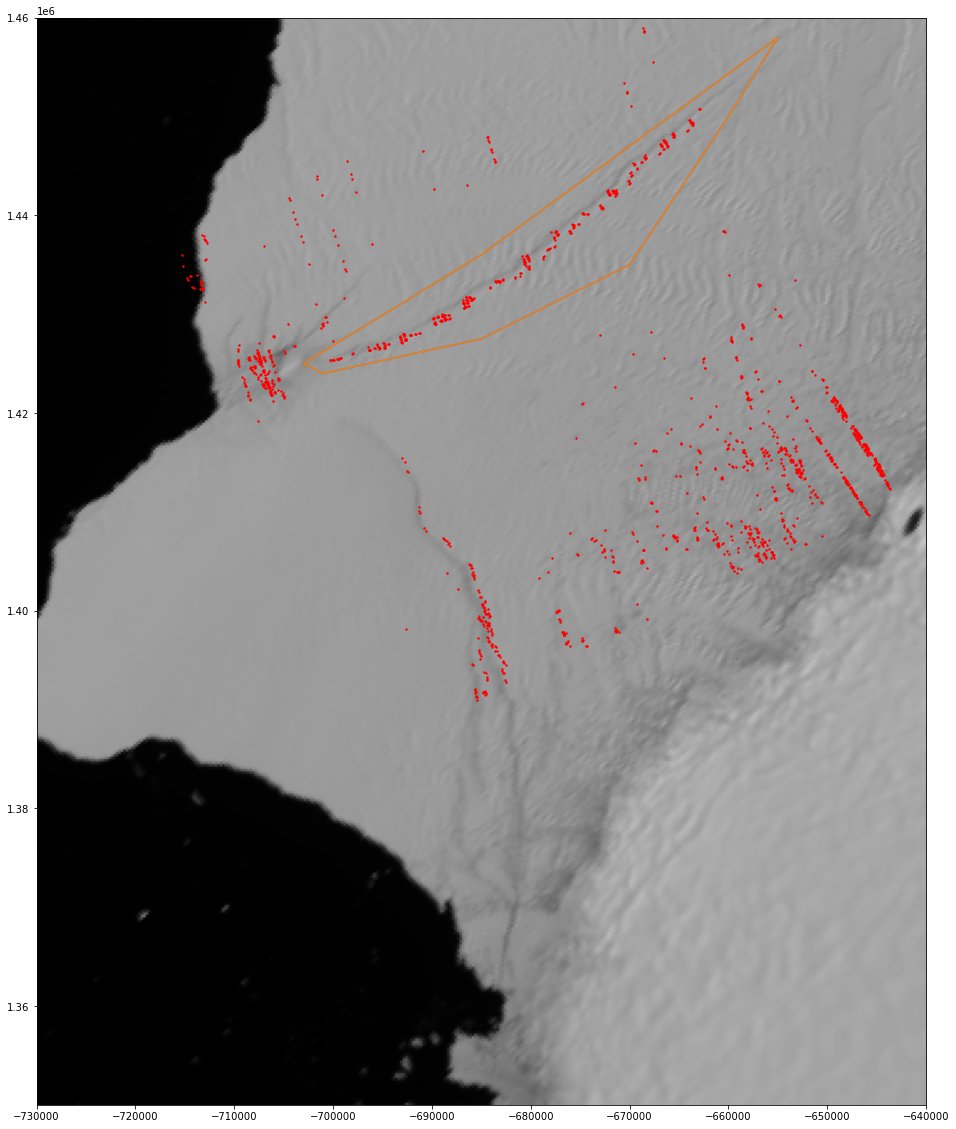

In [850]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import rasterio
from rasterio.plot import show

# image_file = '/Users/lipovsky/Downloads/riise_20_1045_modis_ch02.tif'
image_file = '/Users/lipovsky/Downloads/riise_2020028_1615_modis_ch02.tif'

# Plot catalog over imagery
fig2,ax2 = plt.subplots(figsize=(20,20))
sat_data = rasterio.open(image_file)
show(sat_data,cmap="gray",ax=ax2)
ax2.scatter(rift_obs['x-centroid'] ,rift_obs['y-centroid'] ,s=2,c='r')
window_x = [-7.3e5,-6.4e5]
window_y = [1.35e6,1.46e6]
plt.ylim(window_y)
plt.xlim(window_x)

# plt.ylim([1.424e6,1.453e6])
# plt.xlim([-7.05e5,-6.60e5])

# Make a bounding box and only look at the points within the box

from shapely.geometry import Point, Polygon

coords = [(-701000,1424000), (-685000,1427500), (-670000,1435000), (-660000,1450000),
         (-655000,1458000),(-685000,1436000),(-703000,1425000)]
poly = Polygon(coords)
box_x,box_y = poly.exterior.xy
plt.plot(box_x,box_y)
plt.plot(box_x,box_y)
plt.show()

plt.show()

# Load ITS_LIVE velocities

In [1098]:
from netCDF4 import Dataset    
d = Dataset('/Users/lipovsky/Downloads/ANT_G0120_0000.nc', 'r')
print(d.variables['vx'])
itslive_x =d.variables['x']
itslive_x = np.array(itslive_x)

itslive_y =d.variables['y']
itslive_y = np.array(itslive_y)

itslive_vx=d.variables['vx']
itslive_vy=d.variables['vy']
itslive_ocean=d.variables['ocean']

x_slice = itslive_x[ (itslive_x<max(window_x)) & (itslive_x>min(window_x)) ]
y_slice = itslive_y[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) ]


vx_slice=itslive_vx[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) , 
            (itslive_x<max(window_x)) & (itslive_x>min(window_x))]
vy_slice=itslive_vy[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) , 
            (itslive_x<max(window_x)) & (itslive_x>min(window_x))]
ocean_slice=itslive_ocean[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) , 
            (itslive_x<max(window_x)) & (itslive_x>min(window_x))]
d.close()

# Interpolate.  This will be useful later

# xmesh[0:3,0:3]

from scipy.interpolate import interp2d
vx_interp = interp2d(x_slice, y_slice, vx_slice)
vy_interp = interp2d(x_slice, y_slice, vy_slice)

<class 'netCDF4._netCDF4.Variable'>
float32 vx(y, x)
    units: m/y
    standard_name: x_velocity
    missing_value: -32767.0
    quality_cutoff: 7.0
    map_scale_corrected: 1
    grid_mapping: Polar_Stereographic
unlimited dimensions: 
current shape = (36784, 45792)
filling off


(1433322.7180271347, 1439257.066363115)

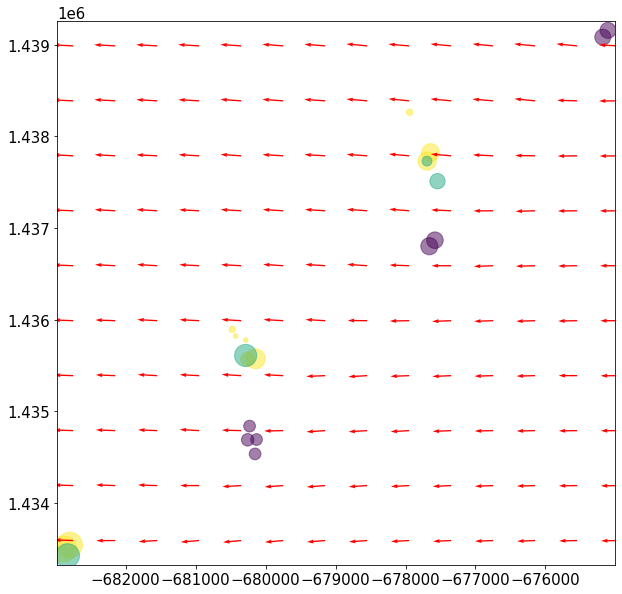

In [703]:
# Unique RGTs:  array([ 154,  215,  276,  283,  344,  596,  657,  718,  725,  786, 1099,
#       1160, 1167, 1228, 1289
# rgt = 596 # Has two nice beam pairs
rgt = 657
ho = rift_obs[rift_obs.within(poly)]
fig2,ax2 = plt.subplots(figsize=(10,10))
ax2.scatter(ho['x-centroid'][ho['rgt']==rgt] ,ho['y-centroid'][ho['rgt']==rgt],
            s=ho['width'][ho['rgt']==rgt],c=ho['time'][ho['rgt']==rgt],alpha=0.5)
skip = 5
c = plt.quiver(xmesh[ ::skip, ::skip],
               ymesh[ ::skip, ::skip],
               vx_slice[ ::skip, ::skip], 
               vy_slice[ ::skip, ::skip], scale=20000, color='r')

plt.xlim((min(ho['x-centroid'][ho['rgt']==rgt])-100, max(ho['x-centroid'][ho['rgt']==rgt])+100))
plt.ylim((min(ho['y-centroid'][ho['rgt']==rgt])-100, max(ho['y-centroid'][ho['rgt']==rgt])+100))

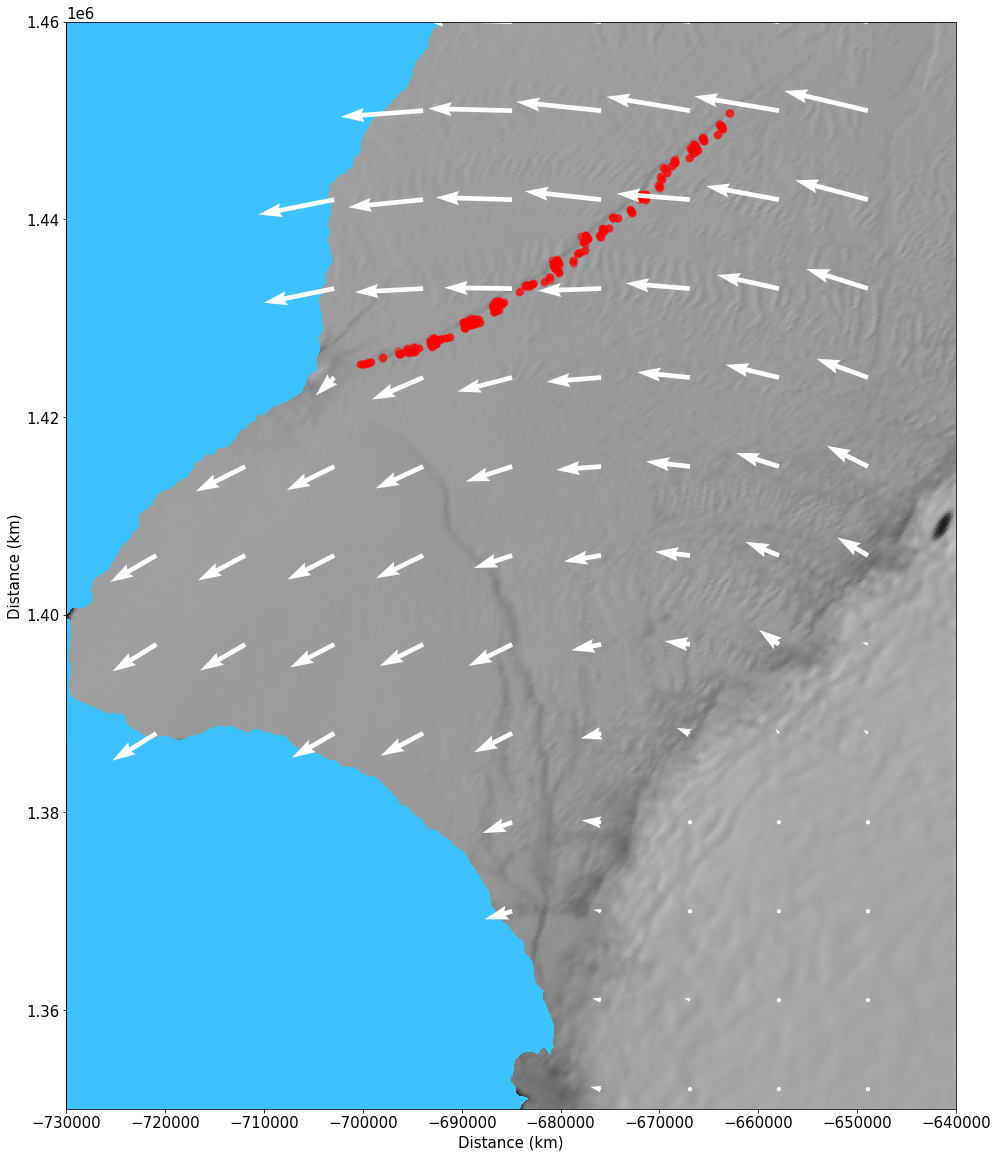

In [837]:
from matplotlib import cm
fig3,ax3=plt.subplots(figsize=(20,20))
xmesh,ymesh = np.meshgrid(x_slice,y_slice)

skip=75
plt.scatter(ho['x-centroid'] ,ho['y-centroid'] ,s=50,c='r',alpha=0.5)
plt.contourf(xmesh,ymesh,ocean_slice,cmap=cm.get_cmap('cool',30))
show(sat_data,cmap="gray",ax=ax3)
c = plt.quiver(xmesh[ ::skip, ::skip],
               ymesh[ ::skip, ::skip],
               vx_slice[ ::skip, ::skip], 
               vy_slice[ ::skip, ::skip], scale=9000, color='w')
plt.axis('image')
plt.ylim(window_y)
plt.xlim(window_x)
plt.rcParams.update({'font.size': 15})
plt.xlabel('Distance (km)')
plt.ylabel('Distance (km)')
plt.show()

# Calculate Strains

In [1021]:
import matplotlib.colors as colors


dvx = np.gradient(vx_slice,y_slice,x_slice)
dvy = np.gradient(vx_slice,y_slice,x_slice)

# With this convention:
# dvx[0] is dvx/dy
# dvx[1] is dvx/dx
# dvy[0] is dvy/dy
# dvy[1] is dvy/dx

# Interpolate
vx_x = interp2d(x_slice, y_slice, dvx[1])
vx_y = interp2d(x_slice, y_slice, dvx[0])
vy_x = interp2d(x_slice, y_slice, dvy[1])
vy_y = interp2d(x_slice, y_slice, dvy[0])


# Verify the catalog
Plot the rift detections along with the ATL06 data.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
atl06_data=pd.DataFrame(atl06_data)


indices = np.unique(rift_obs["data_row"])
n=len(indices)
fig,ax=plt.subplots(figsize=(20,5))

for i in range(1,n):
    index = indices[i]
    if atl06_data.iloc[index]["rgt"] != 657:
        continue

#     d = np.sqrt(atl06_data.iloc[index]["x"]**2 + atl06_data.iloc[index]["y"]**2)
    d = atl06_data.iloc[index]["x_atc"]
    h = atl06_data.iloc[index]["h"] - atl06_data.iloc[index]["geoid"]

    # plt.subplot(n,1,i)
    plt.scatter(d,h,c=atl06_data.iloc[index]["quality"])
    rift_list = arc.find_the_rifts(atl06_data.iloc[index]["h"])
    output = arc.convert_to_centroid(rift_list,atl06_data.iloc[index]["x"],atl06_data.iloc[index]["y"])


    for s in rift_list:
        plt.plot(d[s[0]:s[1]],h[s[0]:s[1]],'-or')
    plt.title('RGT: %i, Beam: %s, Time: %s'%(atl06_data.iloc[index]["rgt"],
                                   atl06_data.iloc[index]["beam"],
                                   atl06_data.iloc[index]["time"]))
    plt.xlabel('X_atc')
        
#     xc = np.array(output['x-centroid'])
#     yc = np.array(output['y-centroid'])
#     dc = np.sqrt(xc**2 + yc**2)
#     for dd,ww in zip(dc,output['width']):
#         xcoords = (dd-ww/2,dd+ww/2)-d[0]
#         plt.plot( xcoords, (0,0),'-ob')
#     #     plt.xlim((0,2e3))

    plt.ylim((-20,100))
    plt.grid()
    fig.savefig('figures_brunt/plot%i.png'%i)    
    fig.clf()

<Figure size 1440x360 with 0 Axes>

# Verify that we loaded the data correctly
by making a plot of the ATL06 data

In [5]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
%matplotlib inline
from datetime import datetime

ttstart = datetime.now()
fig = plt.figure(figsize=[12, 12])
# ax  = plt.subplot(projection=ccrs.SouthPolarStereo())
# ax  = plt.subplot(projection=ccrs.NorthPolarStereo(central_longitude=-81.0))
ax  = plt.subplot(projection=ccrs.PlateCarree())

# ax.coastlines(resolution='50m')
# ax.add_feature(cartopy.feature.LAND)

ax.gridlines(draw_labels=True, dms=True ,  x_inline=False, y_inline=False)

thr = 4
sig_thr = 1


from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
lon_formatter = LongitudeFormatter(number_format='.1f',
                                   degree_symbol='',
                                   dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.1f',
                                  degree_symbol='')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)



for lat, lon, h, q, r in zip(atl06_data['lat'], 
                            atl06_data['lon'], 
                            atl06_data['h'], 
                            atl06_data['quality'],
                            atl06_data['rgt']):
    sc = ax.scatter(lon[q==0],lat[q==0],
                    c=h[q==0],s=1,vmin=15,vmax=30,alpha=0.5,
                    transform=ccrs.PlateCarree())
    if r==95:
        sc = ax.scatter(lon[q==0],lat[q==0],
                    c='r',s=1,vmin=15,vmax=30,alpha=0.5,
                    transform=ccrs.PlateCarree())

# for lat, lon, h, sig in zip(atl06_data['lat'][0:1000], 
#                             atl06_data['lon'][0:1000], 
#                             atl06_data['h'], 
#                             atl06_data['h_sig']):
#     sc = ax.scatter(lon[(h>thr)&(sig<sig_thr)],lat[(h>thr)&(sig<sig_thr)],
#                     c=h[(h>thr)&(sig<sig_thr)],s=1,vmin=0,vmax=30,alpha=0.5,
#                     transform=ccrs.PlateCarree())
plt.colorbar(sc)

# for lat, lon, h, sig in zip(atl06_data['lat'][0:1000], 
#                             atl06_data['lon'][0:1000], 
#                             atl06_data['h'], 
#                             atl06_data['h_sig']):
#     ax.plot(lon[abs(h)<thr],lat[abs(h)<thr],'.r', transform=ccrs.PlateCarree())


plt.show()

ttend = datetime.now()
print('Runtime was: ', ttend - ttstart)

In [10]:
import os
import h5py
import dateutil.parser as dparser
from datetime import datetime
import numpy as np
from pyproj import Transformer
import pickle
import pandas as pd
from netCDF4 import Dataset

import matplotlib.pyplot as plt

# data_directory 
    
# Load BedMachine ice mask.  This is unfortunately a bit slow...
# 0 = ocean, 1 = ice-free land, 2 = grounded ice, 3 = floating ice, 4 = lake Vostok
# maskfile = '/Users/lipovsky/Downloads/BedMachineAntarctica_2019-11-05_v01.nc'
maskfile = '/Users/bradlipovsky/Downloads/BedMachineAntarctica_2020-07-15_v02.nc'
fh = Dataset(maskfile, mode='r')
x = fh.variables['x'][:]
y = np.flipud(fh.variables['y'][:])
mask = np.flipud(fh.variables['mask'][:])

def mask_nearest (x0, y0):
    xi = np.abs(x-x0).argmin()
    yi = np.abs(y-y0).argmin()
    return mask[yi,xi]

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3031")

ttstart = datetime.now()

file_list = os.listdir(data_directory)
files = [f for f in file_list if f.endswith('.h5')]

print("Found %i files in the provided directory"%len(files))

atl06_data = {"lat":list(),"lon":list(),"h":list(),"azimuth":list(),
              "h_sig":list(),"rgt":list(),"time":list(), #"acquisition_number":list(),
              "x":list(), "y":list(), "beam":list(), "quality":np.array(), "x_atc":list(), "geoid":list() }

nf = len(files)
for f in files:
    FILE_NAME = os.path.join(data_directory,f)
    fid = h5py.File(FILE_NAME, mode='r')

    for lr in ("l","r"):
        for i in range(1,4):
            try:
                h_xatc = fid['gt%i%s/land_ice_segments/ground_track/x_atc'%(i,lr)][:]
                h_li = fid['gt%i%s/land_ice_segments/h_li'%(i,lr)][:]
                h_lat = fid['gt%i%s/land_ice_segments/latitude'%(i,lr)][:]
                h_lon = fid['gt%i%s/land_ice_segments/longitude'%(i,lr)][:]
                h_li_sigma = fid['gt%i%s/land_ice_segments/h_li_sigma'%(i,lr)][:]
                seg_az = fid['gt%i%s/land_ice_segments/ground_track/seg_azimuth'%(i,lr)][:]
                rgt = fid['/orbit_info/rgt'][0]
                quality = fid['gt%i%s/land_ice_segments/atl06_quality_summary'%(i,lr)][:]
                time = dparser.parse( fid['/ancillary_data/data_start_utc'][0] ,fuzzy=True )
                beam = "%i%s"%(i,lr)
                geoid = fid['/gt%i%s/land_ice_segments/dem/geoid_h'%(i,lr)][:]
                [h_x,h_y] = transformer.transform( h_lat , h_lon )

            except KeyError:
    #                 print("wtf key error")
                continue

#             This is just used for Brunt:
#                         Not clear why some of the data is out of the region of interest
#                 if any(h_lon>0):
#                     continue

            # Only add the point if is in the ice shelf mask
            this_mask = [float(mask_nearest(XX,YY)) for XX,YY in zip(h_x,h_y)]

            h_lat[ this_mask == 3 ]

            atl06_data["lat"].append( np.array([h_lat[i] for i in range(len(h_li)) if this_mask[i] > 2] ) )

NameError: name 'data_directory' is not defined

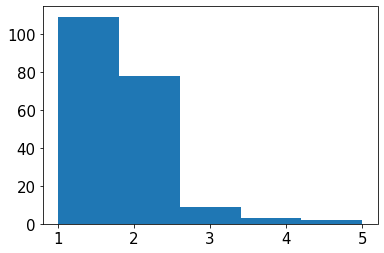

In [283]:
# Detect doublets
reps = []
for r in np.unique(ho['rgt']):
    for t in np.unique(ho['time'][ho['rgt']==r]):
        for b in np.unique(ho['beam'][(ho['rgt']==r) & (ho['time']==t)]):
            reps.append (  len(  ho[(ho['rgt'] == r) & (ho['time'] == t) & (ho['beam'] == b)]))

fig4,ax4=plt.subplots()
plt.hist(reps,5)
plt.show()


# Calculate rift widths and axis angles
assuming that I already have an initial estimate for the orientation of the rift.  This can be added into the KF later.

In [1030]:
from shapely.ops import nearest_points
from pyproj import Geod
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:3031", "EPSG:4326")
geodesic = Geod(ellps='WGS84')

rift_path = pickle.load( open( 'halloween.pickle', "rb" ) )
riftx,rifty = np.array(rift_path.xy)

def estimate_local_rift_orientation(pt,x,y):
    # Given point(x,y), find the two nearest points in approximate_rift_orientation
    # and then return the slope between these two points
    closest = np.argmin( (pt.x-x)**2 + (pt.y-y)**2 )
    [lat1,long1] = transformer.transform( x[closest] , y[closest] )
    [lat2,long2] = transformer.transform( x[closest+1] ,  y[closest+1] )
    fwd_azimuth,back_azimuth,distance = geodesic.inv(long1, lat1, long2, lat2)
    return fwd_azimuth

def estimate_local_rift_orientation_xy(pt,x,y):
    # Given point(x,y), find the two nearest points in approximate_rift_orientation
    # and then return the slope between these two points
    closest = np.argmin( (pt.x-x)**2 + (pt.y-y)**2 )
    dx = x[closest+1] - x[closest]
    dy = y[closest+1] - y[closest]
    fwd_azimuth = np.arctan2(dy,dx) * 180/np.pi
#     print('%f, %f, %f'%(dx,dy,fwd_azimuth))
    return fwd_azimuth


# Next step:  estimate actual rift widths for all obs
# This just involves doing a little bit of trigonometry
azimuth = []
azimuth_xy = []
for index, row in ho.iterrows():
    azimuth.append(estimate_local_rift_orientation(row['geometry'],riftx,rifty))
    azimuth_xy.append(estimate_local_rift_orientation_xy(row['geometry'],riftx,rifty))
actual_width = np.abs(np.sin(np.deg2rad(azimuth - ho['azimuth']))) * ho['width']

# These are the angles of the rift axis
ho['rift-angle'] = pd.Series(np.array(azimuth), index=ho.index)
ho['rift-angle-xy'] = pd.Series(np.array(azimuth), index=ho.index)
ho['actual-width'] = pd.Series(np.array(actual_width), index=ho.index)

# "Kalman Filter" (not really)
At each time-step: 1) add new observations, 2) update old observations, 3) merge observations if they are close enough


In [1117]:
# This version uses pandas in all its glory

time_vector = np.sort(np.unique(ho.time))
time_diff = np.diff(time_vector)
list_of_state_vectors = []
min_seperation_threshold = 0
seperation_list = []
state_vector = pd.DataFrame({'x':np.array([]),'y':np.array([]),'w':np.array([]),
                             't':np.array([]),'a':np.array([])})

for t,i in zip(time_vector,np.arange(len(time_vector))):
    new_obs = ho[ho['time']==t]
    if i>0:
        dt = time_diff[i-1].total_seconds()/86400/365.25 # time step in years
    else:
        dt = np.inf
    print('%i. Found %i new observations at time %s with dt=%s'%(i,len(new_obs),t,dt))
    

    
    # Update the locations of any previous measurements
    if t > min(time_vector):
        
        vx_new = vx_interp(state_vector['x'],state_vector['y']).diagonal()
        vy_new = vy_interp(state_vector['x'],state_vector['y']).diagonal()
        
        # Calculate strain rates
        e11 = vx_x(state_vector['x'],state_vector['y']).diagonal()
        e12 = ( vx_y(state_vector['x'],state_vector['y']).diagonal() 
              + vy_x(state_vector['x'],state_vector['y']).diagonal() ) / 2
        e22 = vy_y(state_vector['x'],state_vector['y']).diagonal()
        
        # Direction cosines of the rift
        dx1 = np.cos(state_vector['a'] * np.pi / 180 + np.pi/2)
        dx2 = np.sin(state_vector['a']* np.pi / 180 + np.pi/2)
        
        # Total stretch on the rift
        dw = e11 * dx1 * dx1 + e12 * dx1 * dx2 + e12 * dx2 * dx1 + e22 * dx2 * dx2
        
        state_vector['x'] = state_vector['x'] + dt * vx_new
        state_vector['y'] = state_vector['y'] + dt * vy_new
        state_vector['w'] = state_vector['w']* (1 + dt * dw )
    
    
    # Add new observations
    add_this = new_obs.rename(columns={"x-centroid": "x", "y-centroid": "y", "width": "w", 
                                       "time": "t", "rift-angle-xy": "a"})
    state_vector = state_vector.append( add_this[["x", "y", "w", "t","a"]] )
    list_of_state_vectors.append(pd.DataFrame(state_vector))

0. Found 2 new observations at time 2018-10-16 17:43:10.115692+00:00 with dt=inf
1. Found 9 new observations at time 2018-10-17 04:36:21.099482+00:00 with dt=0.0012418873358557051
2. Found 9 new observations at time 2018-10-21 04:27:41.966130+00:00 with dt=0.01093495280528304
3. Found 8 new observations at time 2018-11-10 16:27:49.992814+00:00 with dt=0.05612619548647552
4. Found 10 new observations at time 2018-11-15 03:12:21.335674+00:00 with dt=0.012176824056962507
5. Found 8 new observations at time 2018-11-19 03:03:53.403728+00:00 with dt=0.010935307756420005
6. Found 2 new observations at time 2018-12-13 14:55:15.839319+00:00 with dt=0.06706094365829468
7. Found 8 new observations at time 2018-12-14 01:48:05.531424+00:00 with dt=0.0012412126430717165
8. Found 7 new observations at time 2019-01-07 13:39:44.363714+00:00 with dt=0.06706146323833244
9. Found 5 new observations at time 2019-02-05 12:15:56.430749+00:00 with dt=0.07923834724551296
10. Found 8 new observations at time 20

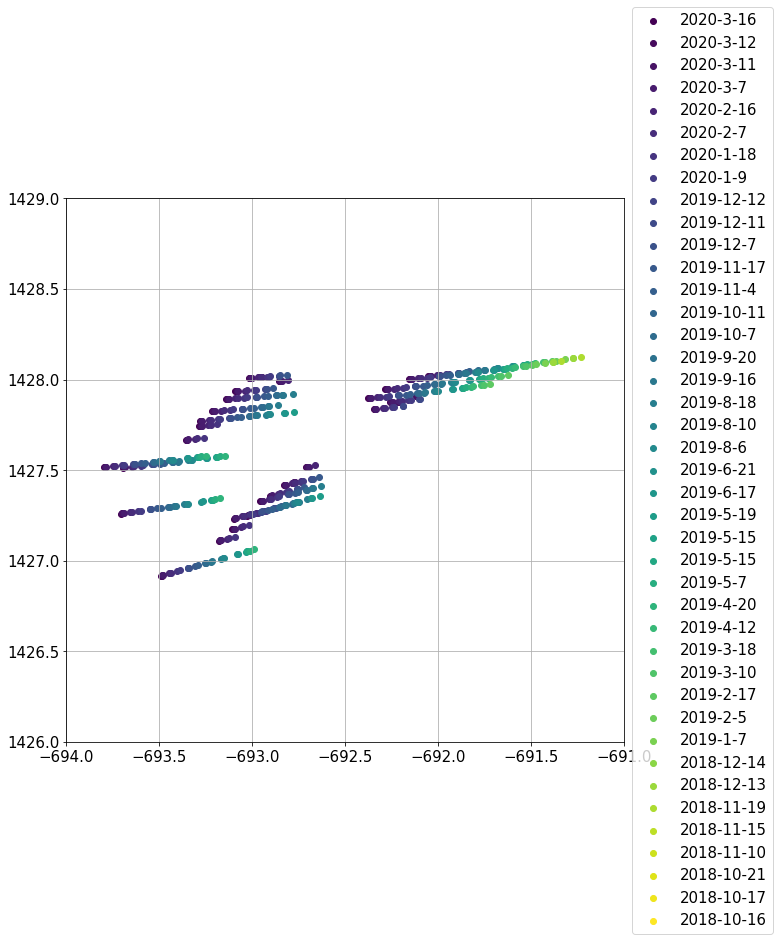

In [972]:
fig7,ax7 = plt.subplots(figsize=(10,10))
color=iter(cm.viridis(np.linspace(0,1,len(list_of_state_vectors))))
for item,t in zip(reversed(list_of_state_vectors),reversed(time_vector)):
    c=next(color)
    plt.scatter(item['x']/1e3,item['y']/1e3,color=c, label='%i-%i-%i'%(t.year,t.month,t.day))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlim((-694,-691))
plt.ylim((1426,1429))
plt.show()

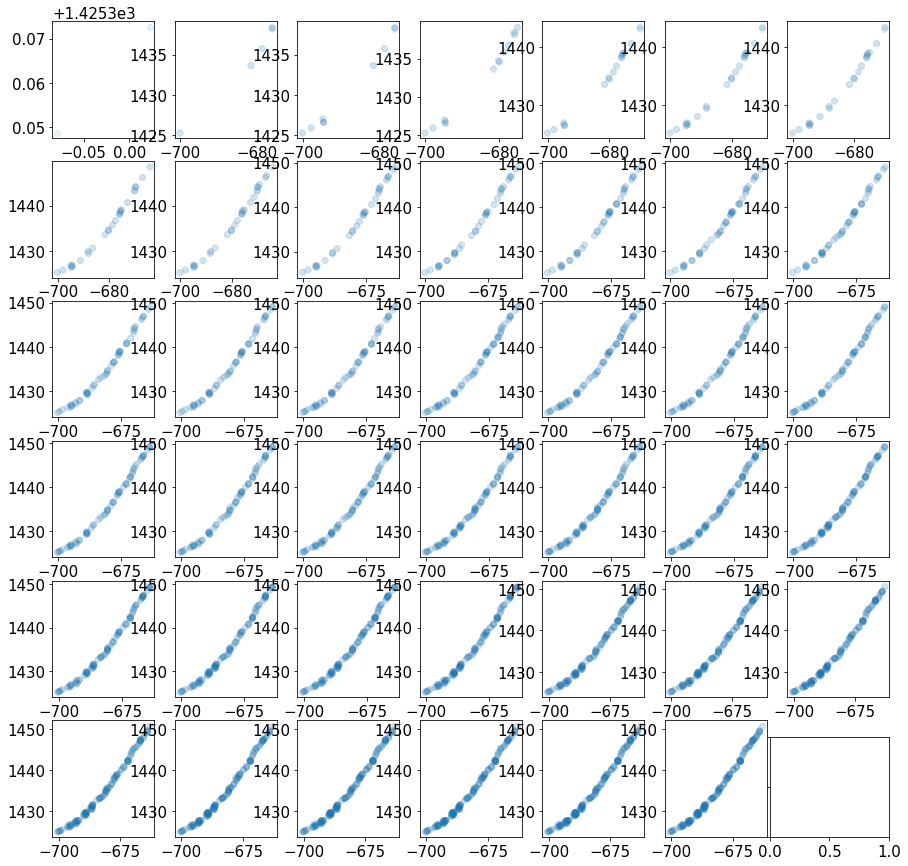

In [946]:
fig9,ax9 = plt.subplots(7, 6,sharex='all', sharey='all',figsize=(15,15))

for item,t,i in zip(list_of_state_vectors,time_vector,np.arange(len(list_of_state_vectors))):
    plt.subplot(6,7,1+i)
    plt.scatter(item['x']/1e3,item['y']/1e3,alpha=0.1)
plt.show()

# Plot a snapshot

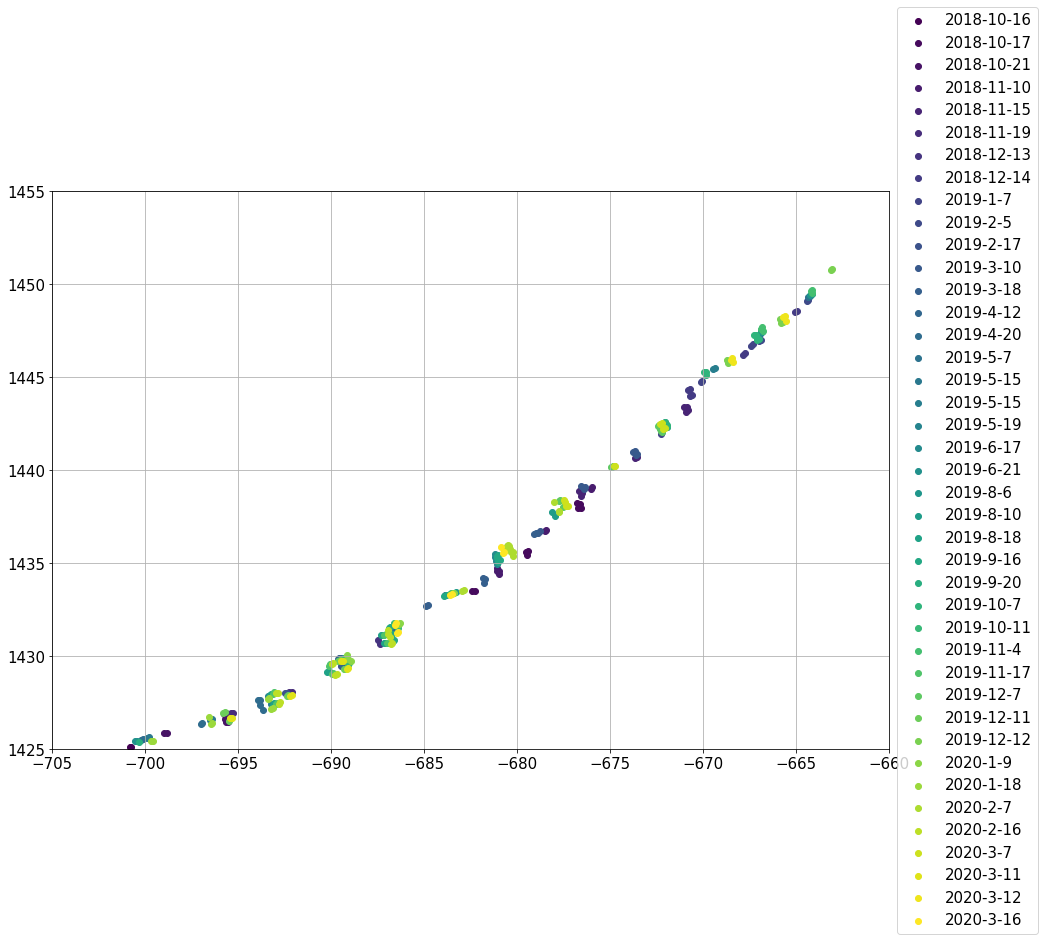

In [1122]:
fig10,ax10 = plt.subplots(figsize=(15,15))
item = list_of_state_vectors[40]

color=iter(cm.viridis(np.linspace(0,1,len(time_vector))))
for t in time_vector:
    c=next(color)
    plt.scatter(item[item['t']==t]['x']/1e3,
                item[item['t']==t]['y']/1e3,
                color=c, label='%i-%i-%i'%(t.year,t.month,t.day))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.axis('image')
plt.xlim((-705,-660))
plt.ylim((1425,1455))
plt.show()

# How close are rift observations?

<Figure size 432x288 with 0 Axes>

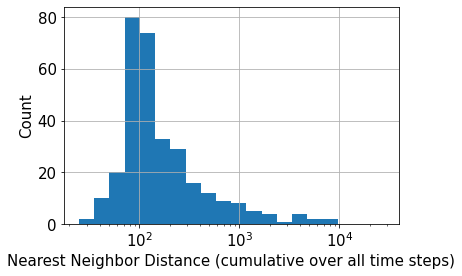

In [977]:
hist, bins, _ = plt.hist(seperation_list, bins=20)

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.clf()
fig8 = plt.subplots()
plt.hist(seperation_list, bins=logbins)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Nearest Neighbor Distance (cumulative over all time steps)')
plt.ylabel('Count')
plt.grid()
plt.rcParams.update({'font.size': 15})
plt.show()

# How does rift width vary?

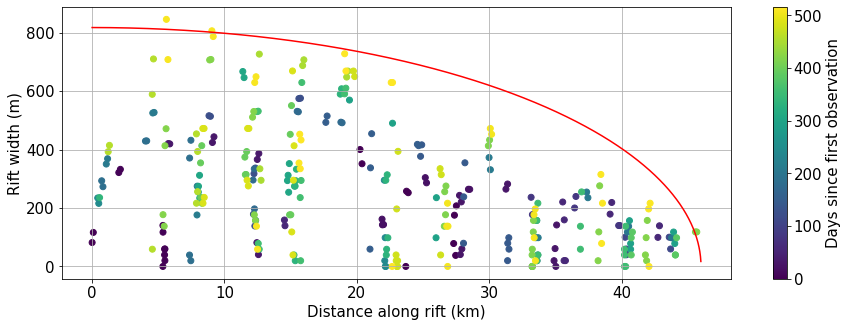

In [1192]:
latest = list_of_state_vectors[-1]

xmin = latest.loc[latest['x'].idxmin()]['x']
ymin = latest.loc[latest['x'].idxmin()]['y']
times = latest['t'].apply(lambda x: (x- latest.iloc[0]['t']).days).values
dist = np.sqrt( (latest['x'].to_numpy()-xmin)**2 + (latest['y'].to_numpy()-ymin)**2 )
fig12 = plt.subplots(figsize=(15,5))
c=plt.scatter(dist/1e3,latest['w'],c=times,label=latest['t'])
xx = np.arange(0,46,0.01)
plt.plot(xx,800*np.sqrt(46**2 - xx**2)/45,'-r')
cbar=plt.colorbar(c)
cbar.set_label('Days since first observation')
plt.xlabel('Distance along rift (km)')
plt.ylabel('Rift width (m)')
plt.grid()
plt.show()

# How different are expected-versus-actual rift widths?

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44])